In [1]:
# Import my code
from tensorfactorization.utils import (defactorizing_CP, create_initial_data, random_cp_with_noise)
from tensorfactorization.multiplicative import (tensor_factorization_cp_multiplicative, tensor_factorization_cp_multiplicative_poisson)
from tensorfactorization.poisson import (BacktrackingWarning, tensor_factorization_cp_poisson, tensor_factorization_cp_poisson_fixed_step_size)

from toolkit.constants import (
    picture_folder, data_folder, 
    error_label, iteration_label, tensor_dimension_label, time_label, 
    xscale_convergence_data, xscale_convergence, yscale_convergence
)
from toolkit.classes import (
    IterationResult,
    Factorizer
)
from toolkit.evaluate import (
    evaluate_on_random, evaluate_on_data, evaluate_on_images, 
    plot_calculation_times_and_niter
)

#%matplotlib widget
import tensorly as tl
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pickle # use pickle to save results to disk
import warnings

from copy import deepcopy

## Evaluate All Algorithms


Testing on random generated tensors:
Dimension of tensor: (10, 10, 10), noise: 0.06626769189080746, F: 5, norm: 75.49329615792736
Multiplicative converged in 0.631 seconds and 908 iterations
Multiplicative Poisson converged in 2.111 seconds and 883 iterations
Geometric step size calculation with mean = 1 converged in 0.554 seconds and 107 iterations
Dimension of tensor: (20, 20, 5), noise: 0.08998117377540184, F: 5, norm: 99.50869103640491
Multiplicative converged in 0.833 seconds and 1130 iterations
Multiplicative Poisson converged in 1.388 seconds and 632 iterations
Geometric step size calculation with mean = 1 converged in 0.983 seconds and 199 iterations
Dimension of tensor: (10, 10, 10, 5), noise: 0.13658818603984157, F: 5, norm: 169.96701802663247
Multiplicative converged in 0.443 seconds and 430 iterations
Multiplicative Poisson converged in 0.676 seconds and 201 iterations
Geometric step size calculation with mean = 1 converged in 1.040 seconds and 129 iterations
Dimension of 

C:\Users\David\.conda\envs\tensor_factorization\lib\site-packages\tensorly\backend\pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


Multiplicative converged in 1.676 seconds and 1103 iterations
Multiplicative Poisson converged in 4.105 seconds and 753 iterations
Geometric step size calculation with mean = 1 converged in 5.684 seconds and 271 iterations

Testing on vaccine data:
Tensor is of shape: torch.Size([1516, 12, 14])
Multiplicative converged in 1.746 seconds and 2001 iterations
Multiplicative Poisson converged in 4.110 seconds and 2001 iterations


C:\Users\David\Documents\GitHub\GeometricTensorFactorization\tensorfactorization\poisson.py:150: BacktrackingWarning: Backtracking did not converge in time so we skip this update.
  warnings.warn("Backtracking did not converge in time so we skip this update.", BacktrackingWarning)


Geometric step size calculation with mean = 1 converged in 3.037 seconds and 63 iterations

Factorizing image colorwheel with F = 5
Multiplicative converged in 0.513 seconds and 358 iterations
Multiplicative Poisson converged in 0.247 seconds and 80 iterations
Geometric step size calculation with mean = 1 converged in 2.936 seconds and 107 iterations

Factorizing image cat with F = 6
Multiplicative converged in 0.762 seconds and 691 iterations
Multiplicative Poisson converged in 1.519 seconds and 552 iterations
Geometric step size calculation with mean = 1 converged in 2.054 seconds and 245 iterations

Factorizing image coffee with F = 6
Multiplicative converged in 0.707 seconds and 480 iterations
Multiplicative Poisson converged in 0.858 seconds and 228 iterations
Geometric step size calculation with mean = 1 converged in 1.019 seconds and 103 iterations

Factorizing image astronaut with F = 9
Multiplicative converged in 1.850 seconds and 1468 iterations
Multiplicative Poisson converg

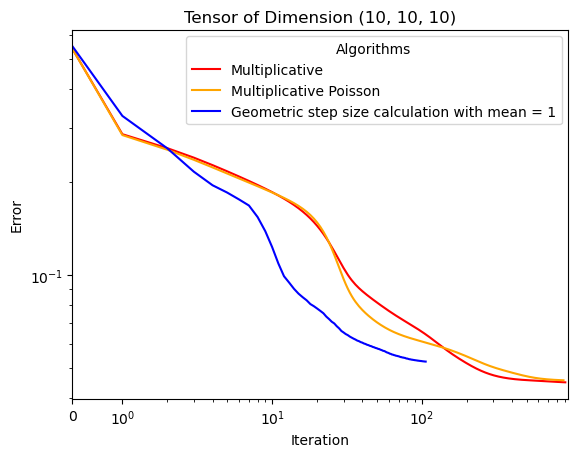

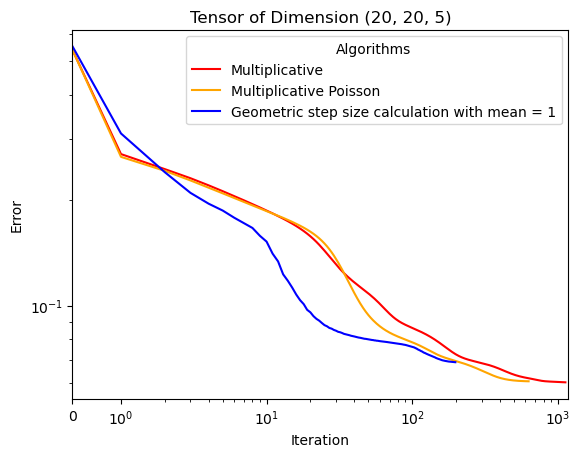

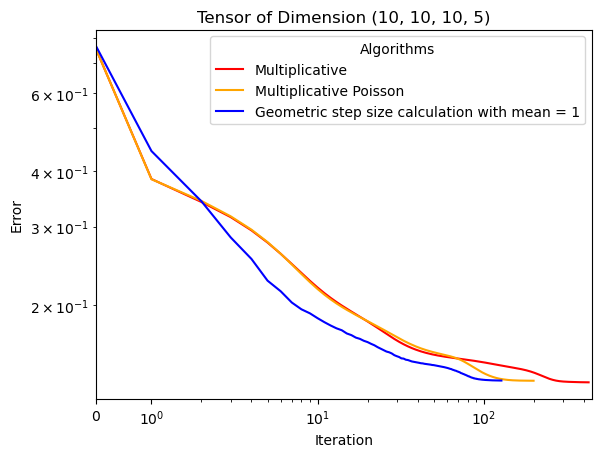

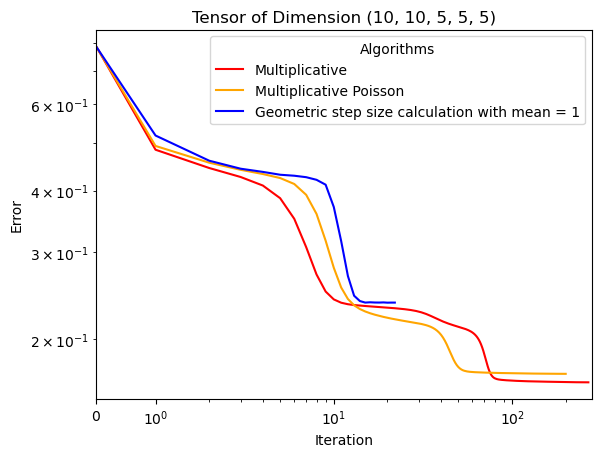

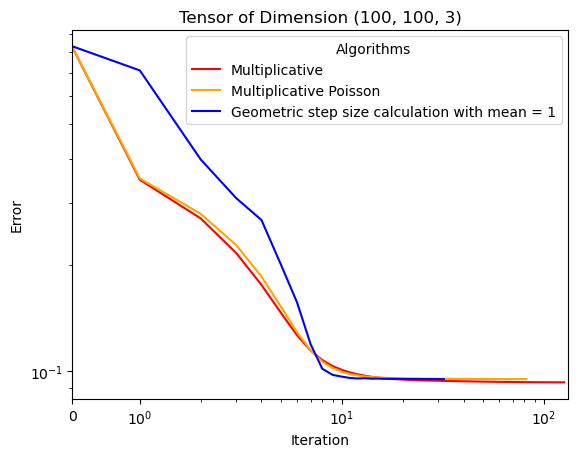

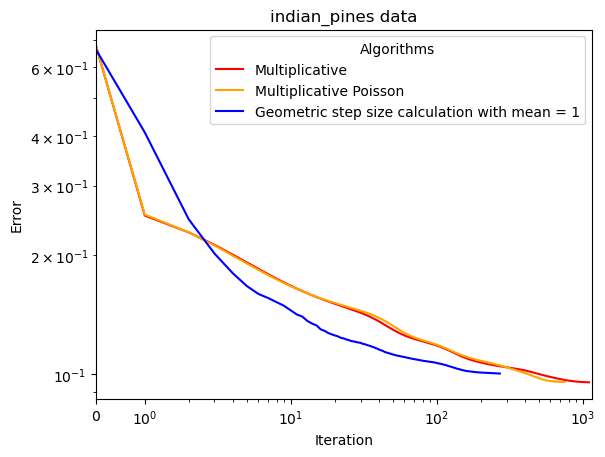

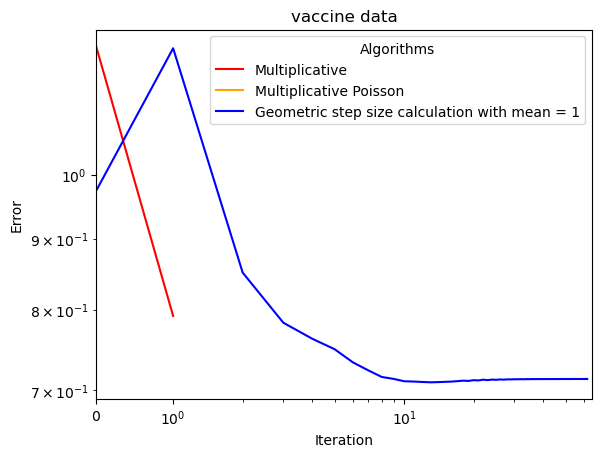

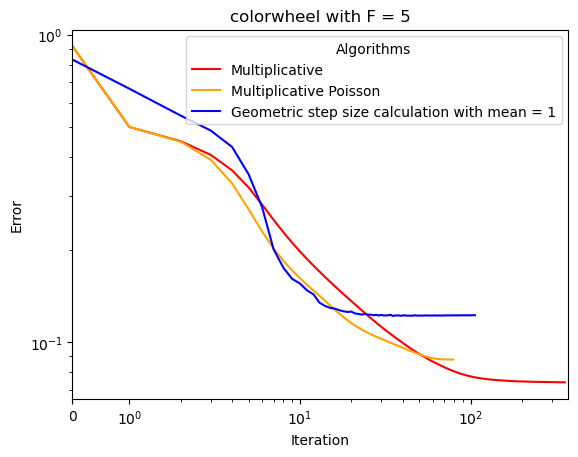

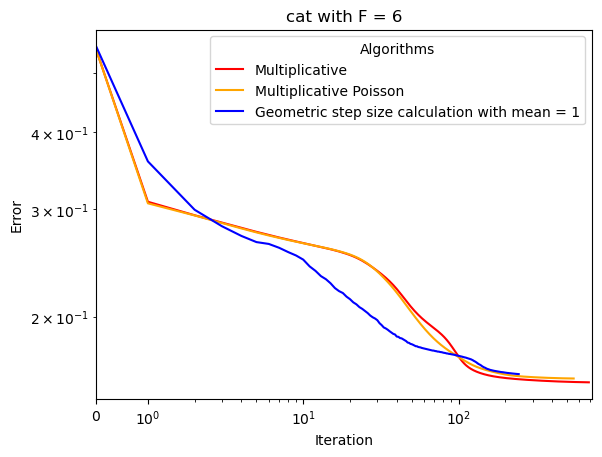

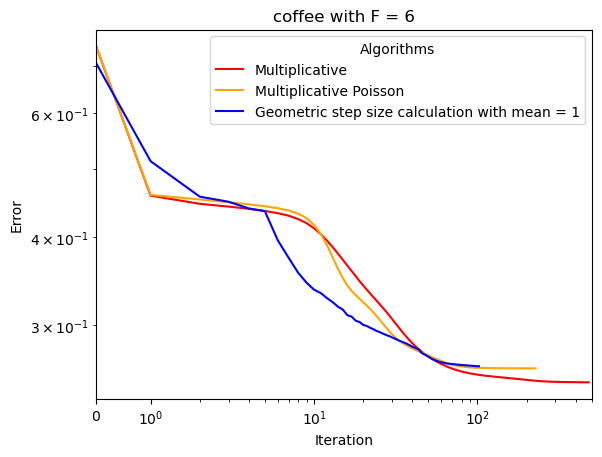

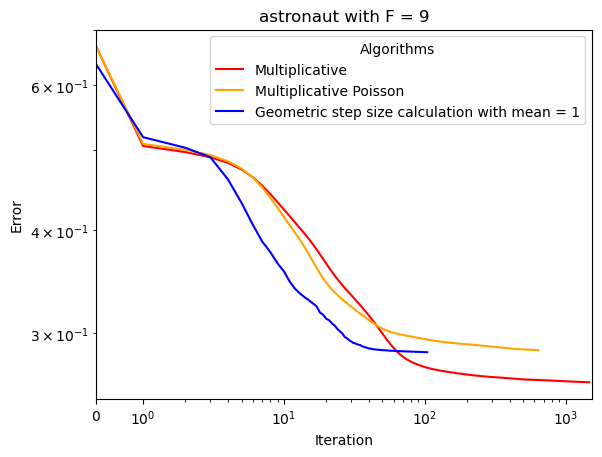

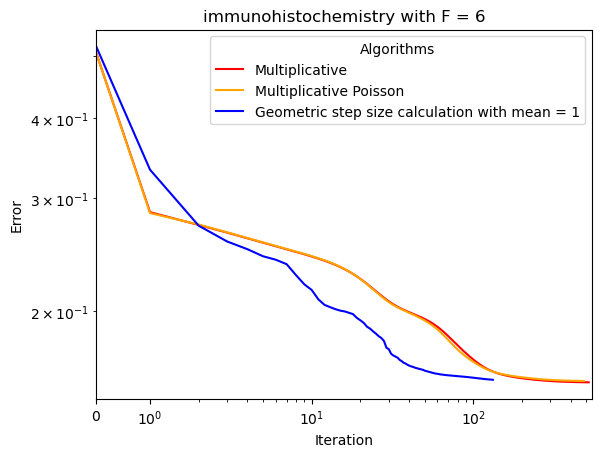

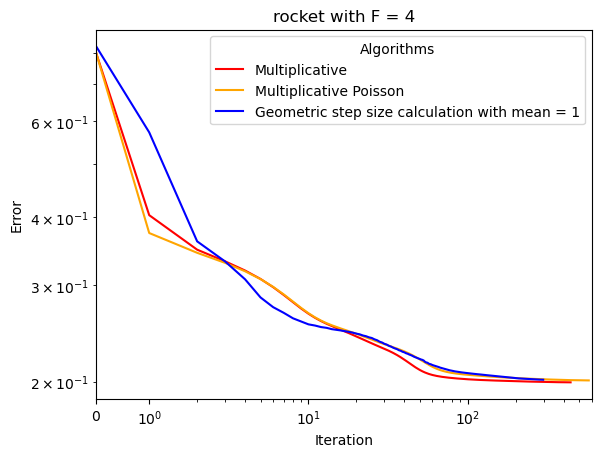

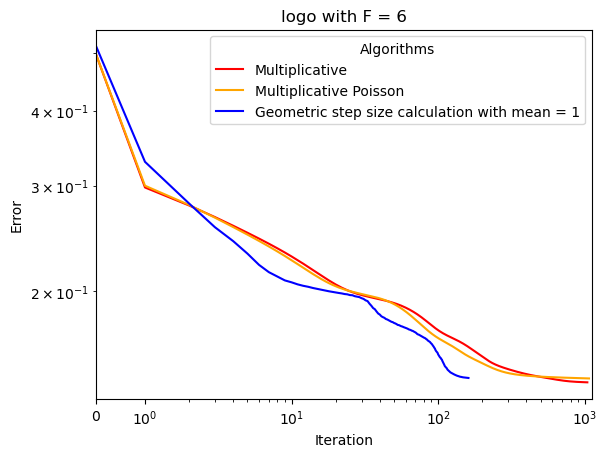

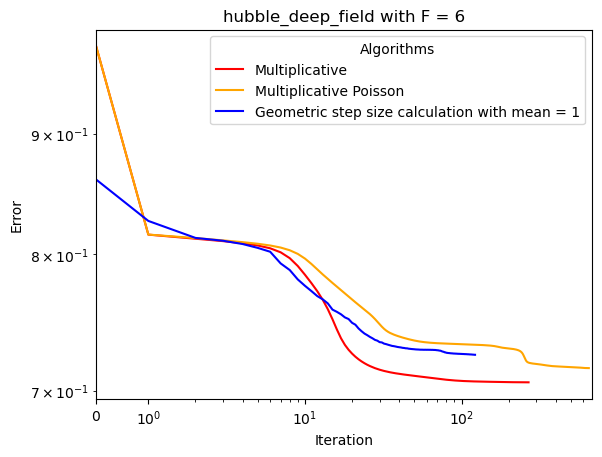

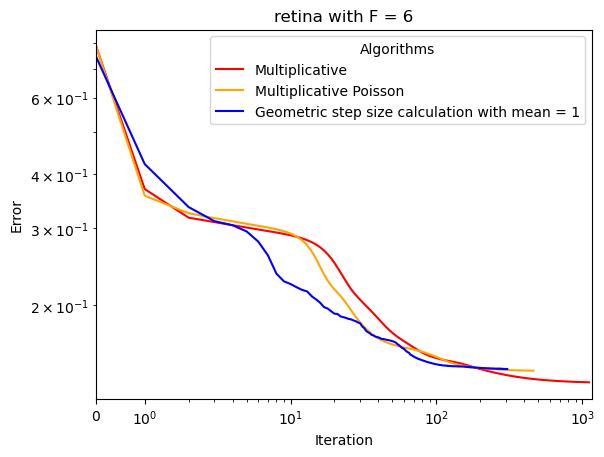

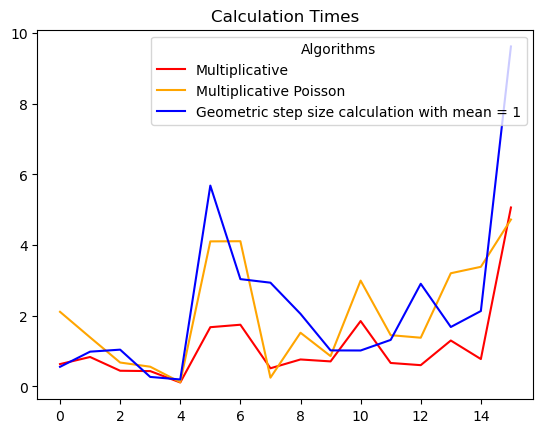

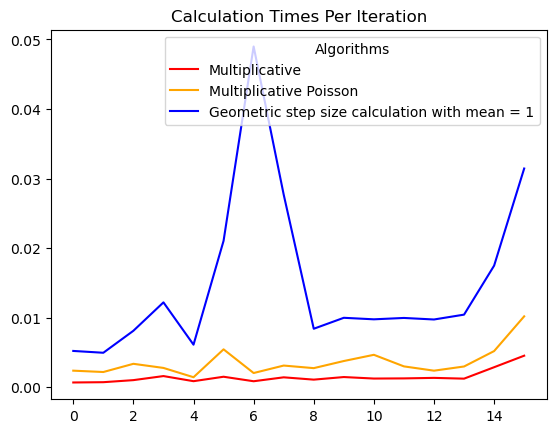

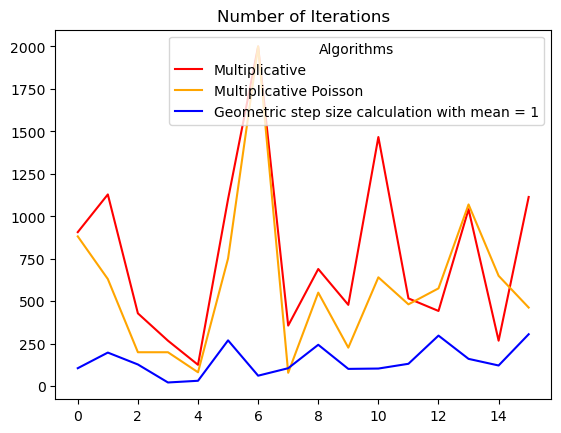

In [2]:
# CREATE FACTORIZER OBJECTS FOR ALL ALGORITHMS
max_iter = 2000

# The standart multiplicative algorithm
def multiplicative_factorization(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _ = tensor_factorization_cp_multiplicative(tensor, F, max_iter=max_iter, detailed=True, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_multiplicative = Factorizer("Multiplicative", multiplicative_factorization, color='red')

# The Poisson variant of the multiplicative algorithm
def multiplicative_poisson_factorization(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _ = tensor_factorization_cp_multiplicative_poisson(tensor, F, max_iter=max_iter, detailed=True, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_multiplicative_poisson = Factorizer("Multiplicative Poisson", multiplicative_poisson_factorization, color='orange')


# The new geometric algorithm with step size calculation and without any form of normalization
def geometric_variable_step_size(tensor, F, initial_A_ns):
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric = Factorizer("Geometric step size calculation without rescaling", geometric_variable_step_size, color='blue')

# The new geometric algorithm with step size calculation and but normalization of the tensor and the initial data
def geometric_variable_normalized(tensor, F, initial_A_ns):
    # copy tensor and initial data and rescale
    norm_of_tensor = tl.norm(tensor)
    tensor_copy = tensor / norm_of_tensor # normalize tensor
    norm_of_approximation = tl.norm(defactorizing_CP(initial_A_ns, tensor.shape))
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / norm_of_approximation) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_norm = Factorizer("Geometric step size calculation with normalization", geometric_variable_normalized, color='blue', linestyle='dotted')

# The new geometric algorithm with step size calculation and but max=1 of the tensor and the initial data
def geometric_variable_normalize_max(tensor, F, initial_A_ns):
    # copy tensor and initial data and rescale
    tensor_copy = tensor / tl.max(tensor) # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.max(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_max = Factorizer("Geometric step size calculation with max = 1", geometric_variable_normalize_max, color='blue', linestyle='dashed')

# The new geometric algorithm with step size calculation and but mean=1 of the tensor and the initial data
def geometric_variable_normalize_mean(tensor, F, initial_A_ns):
    # copy tensor and initial data and rescale
    tensor_copy = tensor / tl.mean(tensor) # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.mean(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson(tensor_copy, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns_copy)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_mean = Factorizer("Geometric step size calculation with mean = 1", geometric_variable_normalize_mean, color='blue', linestyle='solid')



# default geometric algorithm with fixed step size. Use normalize the mean of the tensor to get some form of normalization
def geometric_fixed_step_size(tensor, F, initial_A_ns):
    # copy tensor and initial data and rescale
    tensor_copy = tensor / tl.mean(tensor) # normalize tensor
    initial_A_ns_copy = deepcopy(initial_A_ns)
    scaling = (1.0 / tl.mean(defactorizing_CP(initial_A_ns_copy, tensor.shape))) ** (1.0/ tensor.ndim)
    for n in range(len(initial_A_ns_copy)):
        initial_A_ns_copy[n] = initial_A_ns_copy[n] * scaling
    start = time.time()
    A_ns, RE, _, _ = tensor_factorization_cp_poisson_fixed_step_size(tensor, F, max_iter=max_iter, detailed=True, verbose=False, initial_A_ns=initial_A_ns)
    end = time.time()
    return IterationResult(tl.tensor(RE), end-start, A_ns)
factorizer_geometric_fixed = Factorizer("Geometric fixed step size", geometric_fixed_step_size, color='green')


# run the factorization on gpu
tl.set_backend('pytorch')
context = {'dtype': tl.float32,
           'device': 'cuda'}
#context = {}
factorizers = [
    factorizer_multiplicative,
    factorizer_multiplicative_poisson,
    #factorizer_geometric,
    #factorizer_geometric_norm,
    #factorizer_geometric_max,
    factorizer_geometric_mean,
    #factorizer_geometric_fixed,
]
evaluate_on_random(factorizers, context=context)
evaluate_on_data(factorizers, context=context)
evaluate_on_images(factorizers, context=context)
plot_calculation_times_and_niter(factorizers)

In [ ]:
test = [False] * 3
print(test)
print(all(test))